# Classification of pitches

The goal here is to classify the types of pitches thrown by a given pitcher. Though the pitchfx data comes with pitch classfications, it is known to not be very reliable ("It is accurate enough for most work that involves differentiating between fastballs and off-speed pitches"--Fast, "What the heck is PitchFX?"). Additionally, clustering is a relatively simple task to perform with PitchFX and has a good chance to be able to separate pitches.

To start, we will link the relevant libraries.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Gathering data

For our classification, we will choose one pitcher to examine. Let's choose 'Barry Zito', who we observed briefly in our EDA. He is known for the break of his curveball and a below-average fastball.

### Connecting to database

Let's specificy the database name and path, then connect to the database.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

### Selecting pitches

We'll query our database to get all the pitches he threw in 2008.  Note that we will not worry about sorting the pitches by pitch number since we are just clustering pitches. Additionally, the *pitchfx* table does not have the pitcher id stored. Instead, we have to link the *pitchfx* table to the *events* table to get player id information. We'll print out the first five pitches.

In [3]:
query = """SELECT DISTINCT pitchfx.* 
    FROM pitchfx
    JOIN events ON (pitchfx.game_id=events.game_id
        AND pitchfx.prev_event=events.event_id)
    WHERE events.pitcher_id=(SELECT player_id
        FROM players
        WHERE players.player_first='Barry'
            AND players.player_last='Zito')
    ORDER BY game_id, pitch_num"""
bz_pfx = pd.read_sql_query(query, db)
bz_pfx.head()

game_id  pitch_num  at_bat      time  prev_event      description outcome  \
0   233769         30       4  134206.0           7             Ball       B   
1   233769         31       4  134217.0           7    Called Strike       S   
2   233769         32       4  134228.0           7             Foul       S   
3   233769         33       4  134247.0           7  In play, no out       X   
4   233769         37       5  134336.0           8             Ball       B   

   pre_balls  post_balls  pre_strike     ...        vz0     ax      ay  \
0          0           1           0     ...     -4.167 -4.395  28.973   
1          1           1           0     ...     -7.852 -1.776  29.654   
2          1           1           1     ...     -2.479  3.593  22.606   
3          1           1           2     ...     -5.803 -1.431  30.550   
4          0           1           0     ...     -2.421 -3.625  31.828   

       az  break_y  break_angle  break_length  spin_dir  spin_rate  pitch_type  
0 -13.125     23.7         16.5           3.9   192.990   2278.601          FC  
1  -9.818     23.7          8.9           3.2   184.540   2620.543          FF  
2 -23.886     23.7         -8.3           9.2   156.564   1243.876          CH  
3  -8.798     23.7         12.1           2.8   183.501   2732.740          FF  
4 -12.756     23.6         18.5           3.8   190.573   2300.700          FF  

[5 rows x 36 columns]

## Data cleaning and feature selection

The goal here is to classify pitches ourselves, as we saw from EDA that there are some apparent pitch misclassifications (for instance, some cutters seemed to be grouped with sliders when looking at movement information).

From EDA we saw that the pitch data for Barry Zito contains a number of Nans. Fortunately, the Nans appeared to be spread out throughout data observations (such they appear somewhat random over time and are unlikely to add any bias), and they were only present in 3% of the pitches. We could choose to impute some of the missing values for a given observation, but from EDA we saw that where there were Nans for a given pitch, nearly all of the columns related to trajectory were missing. Therefore, we'll drop the pitches containing any Nans rather than try to fill them in based on only situational information.

In [4]:
# number of data points before
print("number of observations including nans: ", bz_pfx.shape[0])

# drop nans
bz_pfx = bz_pfx.dropna(axis=0, how="any")

# number of data points after
print("number of observations without nans: ", bz_pfx.shape[0])

number of observations including nans:  3206
number of observations without nans:  3102


From PCA, we saw that the first principal component (which explained 30% of the total variance in the data) was primarily a measure of pitch trajectory, while the subsequent components were measures of pitch location and situtational information (which explained less than 15% of the variance in the data each). Since the goal here is pitch classification, we will keep only columns related to trajectory information tied to the first principal component for clustering (which we saw from EDA). Note that we will keep `pitch_type` for now, as it contains the pitch classifications from the database.

Decriptions of these pitch variables can be found here: https://fastballs.wordpress.com/category/pitchfx-glossary. We'll also drop pitches that are classified as intential balls ("IN") and pitch outs ("PO").

In [5]:
# drop pitches that are intential balls and pitch outs
bz_pfx = bz_pfx[bz_pfx.pitch_type!="IN"]
bz_pfx = bz_pfx[bz_pfx.pitch_type!="PO"]

# drop columns
bz_pfxc = bz_pfx.drop(["game_id",
                       "pitch_num",
                       "at_bat",
                       "time",
                       "prev_event",
                       "description",
                       "outcome",
                       "pre_strike",
                       "post_strike",
                       "pre_balls",
                       "post_balls",
                       "sz_top",
                       "sz_bot",
                       "pz",
                       "px",
                       "x",
                       "y",
                       "y0",
                       "x0",
                       "z0",
                       "break_y"], 1)

While we saw from EDA that a number of columns are highly correlated (e.g., `start_speed` and `end_speed`), we will keep them for now in our pitch clustering analysis.

## Clustering pitches

We will use clustering methods to classify pitches. This is an unsupervised learning technique, and we will need to interpret the resulting groups of clusters. We will compare our classifications to those from the database.

### Based on features from intuition

Let's try hierarchical clustering since we do not know the number of clusters beforehand. All data points begin as their own cluster, in some ways. Then we fuse data points together that are similar to each other, and continue until all data points are in one cluster. There are some controls over how clusters are fused. There are five common types of linkage (complete, average, single, centroid, ward). There are also dissimilarity measures, such as Euclidean distance and correlation-based distances. For the case of pitch classification, we will start for Euclidean distance, as we're looking for feature values with similar values.

Start by importing the clustering object from scipy.

In [6]:
# import
import scipy.cluster.hierarchy as hier

Remember that we should standardize the features (mean 0, standard deviation 1) before clustering, as we do not want distances (here Euclidean) to be biased by one feature. We'll focus on just the three features from intuition (`start_speed`, `ax`, and `az`).  We'll avoid adding more features for now, as we would like to avoid the clustering problems associated with higher-dimensional data.

In [7]:
# subset of pitches
pitches_intuit = bz_pfxc[["ax",
                          "az",
                          "start_speed"]]

Now let's perform hierarchical clustering on the data. We'll use the Ward variance minimization algorithm for the linkage, which treats the analysis as a variance problem rather than similarity problem.

In [8]:
# generate linkage matrix
hclust_intuit = hier.linkage((pitches_intuit-pitches_intuit.mean())/pitches_intuit.std(),
                              method='ward',
                              metric='euclidean')

Now let's plot the corresponding dendrogram, colored by a cutoff of 25.

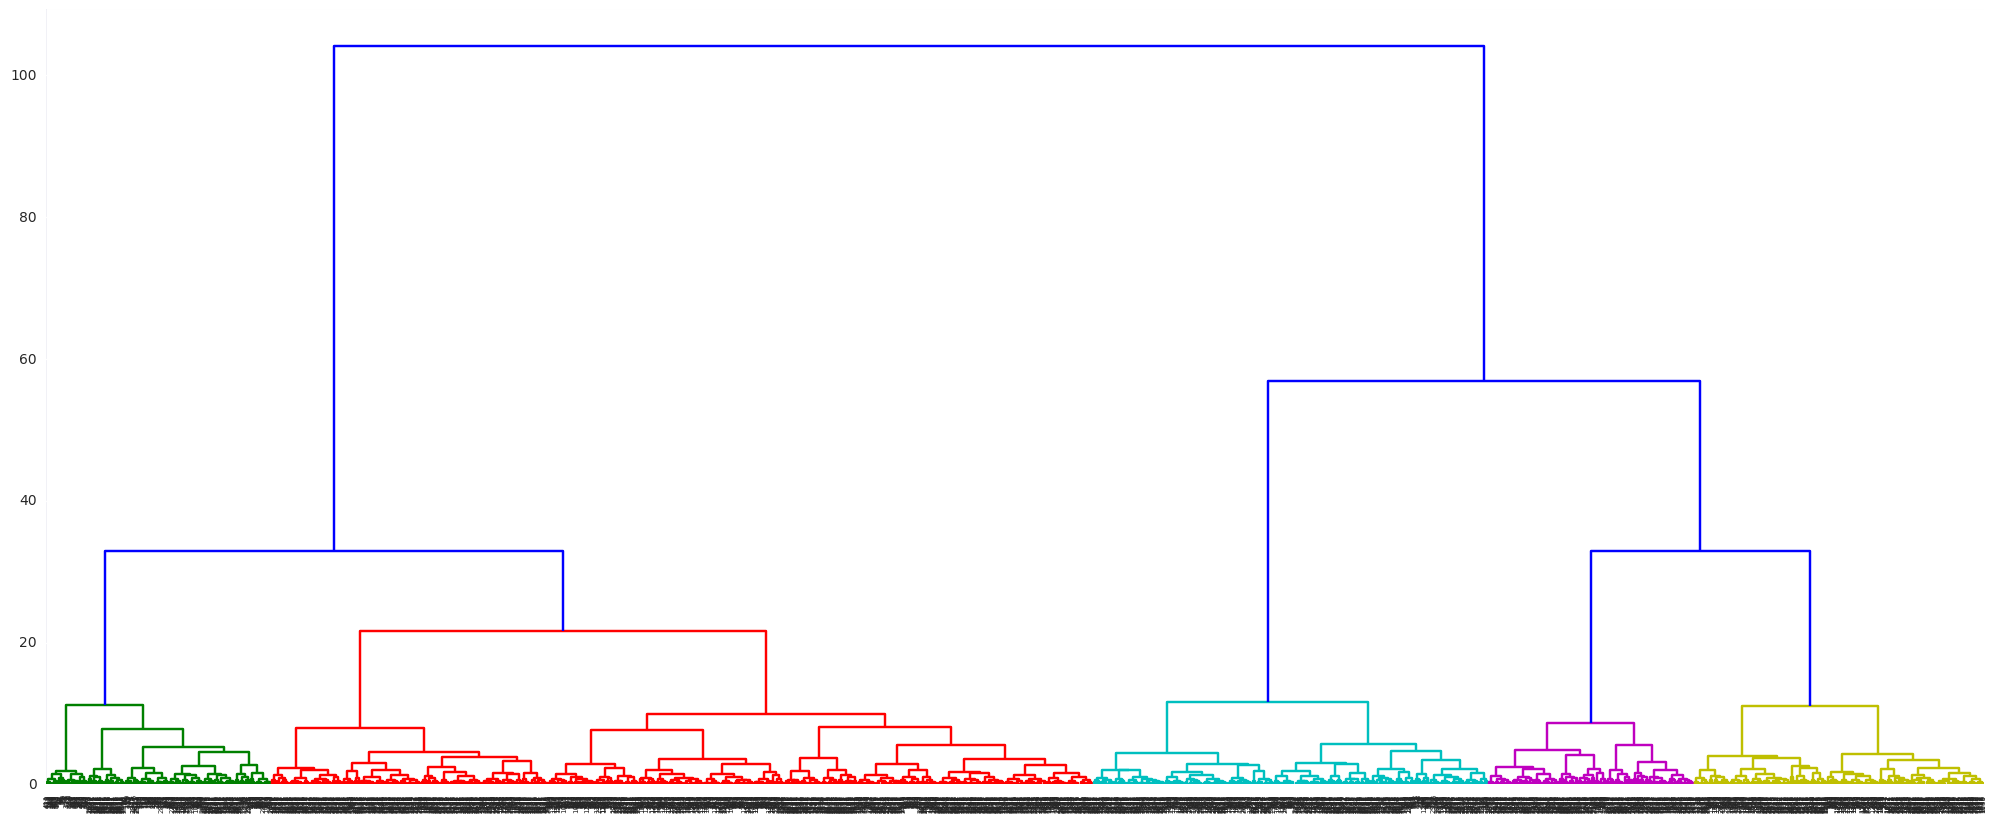

In [9]:
# plot the dendrogram colored by a certain height
hcut = 25
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_intuit,
                        color_threshold=hcut,
                        leaf_rotation=90)

We see that with this clustering, we get 5 clear clusters. Let's project the cluster classification back onto our original feature axes using a crossplot function.

In [10]:
# create function for cross plots
def xplot3(dataframe3, ax0, ax1, ax2, *label):
    """Create crossplots of over three variables
    
    Input:
        dataframe3: pd dataframe
        ax0: feature string 1
        ax1: feature string 2
        ax2: feature string 3
        label: optional color label (if not specified then plots the third axis)
        
    Outputs:
        crossplots over all combinations of three features
    """
    # check if color label
    if label:
        col = [label[0] for ii in range(3)]
    else:
        col = [dataframe3[ax2], dataframe3[ax0], dataframe3[ax1]]

    # initialize subplots and feature vector
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    axes = [ax0, ax1, ax2, ax0, ax1]
    
    # loop over figures
    for ii in range(3):
        pp = ax[ii].scatter(dataframe3[axes[ii]],
                            dataframe3[axes[ii+1]],
                            c=col[ii],
                            cmap="jet",
                            alpha=0.2)
        ax[ii].set_xlabel(axes[ii])
        ax[ii].set_ylabel(axes[ii+1])
        if label:
            plt.colorbar(pp, ax=ax[ii])
        else:
            plt.colorbar(pp, ax=ax[ii], label=axes[ii+2])
    
    plt.show()
    
    # clean up
    return

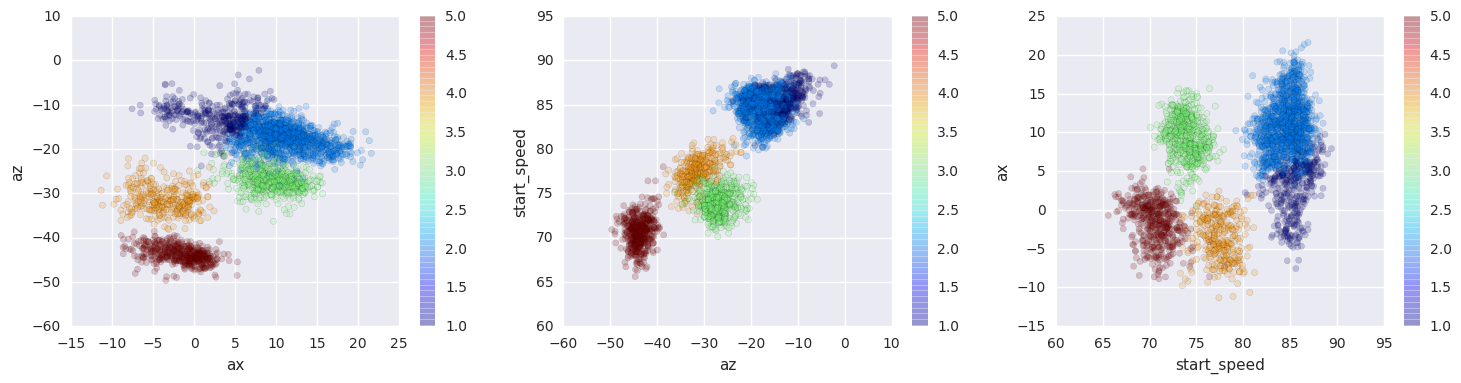

In [11]:
# labels
hlabel_intuit5 = hier.fcluster(hclust_intuit, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_intuit5)

We can see that the clusters look reasonable. Interestingly, the large cluster at the highest velocities got broken into two. Based on the feature values associated with each of these clusters, the light blue group is likely his four-seam fastball, the dark blue cluster is likely his two-seam fastball (which tails from left to right), the green cluster is likely his changeup, the orange cluster is likely his slider (breaks right to left), and his red cluster is likely his notorious curveball.

These pitch classification descriptions are based on the pitch chart in https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/ (flip for left-handed pitchers).

Let's compare our results to the pitch classifications from our database.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


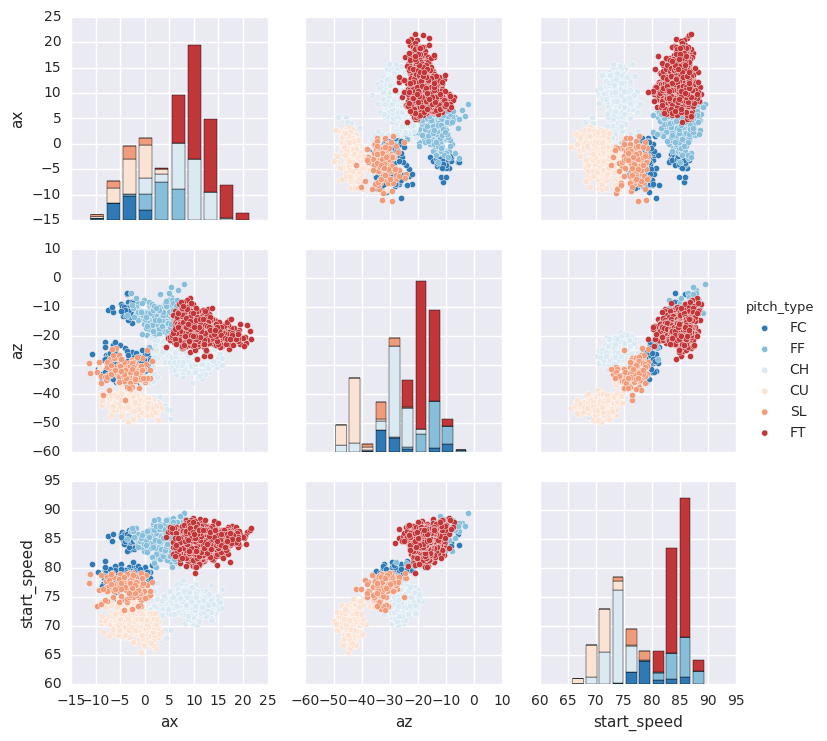

In [12]:
## pitch type from database
#pclass = pitch_info["pitch_type"].astype('category').cat.codes
#
## project label onto data points
#plt.scatter(pitches["ax"], 
#            pitches["start_speed"], 
#            c=pclass, 
#            cmap="jet",
#            alpha=0.5)
#plt.xlabel("Horizontal acceleration (ft/s2)")
#plt.ylabel("Start speed (mph)")
#plt.show()

# pitch type from database
pitches_intuit["pitch_type"] = bz_pfxc["pitch_type"]
sns.pairplot(data=pitches_intuit,
             hue="pitch_type",
             palette="RdBu_r")
pitches_intuit = pitches_intuit.drop("pitch_type", 1)
plt.show()

As we can see, the pitch classifications here are quite different from our pitch classification. Looking at `ax` vs `start_speed`, we can see that the cutter (blue) is found in both the primary clusters for the four-seamer (green-blue) and the slider (pink). While it is possible that the cutter does exist, it is difficult to believe that it is also that similar to his slider. Therefore, it looks like our clustering algorithm might be doing a better job than what was provided by PitchFX, although with one fewer pitch type.

However, since the data base suggests that there are six pitch types, let's actually go back and pull out the sixth cluster from our hierarchical clustering and see what we get.

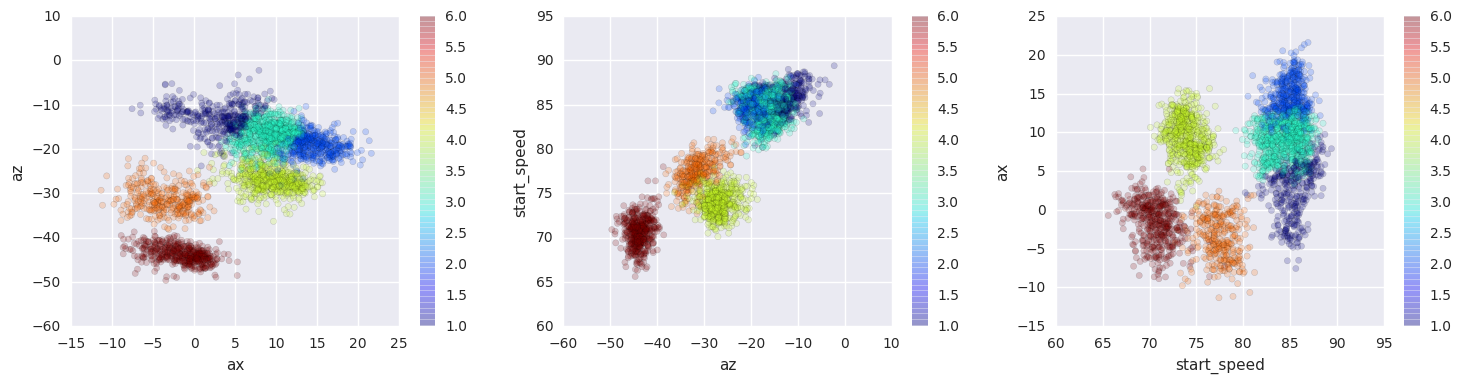

In [13]:
# labels
hcut = 18
hlabel_intuit6 = hier.fcluster(hclust_intuit, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_intuit6)

With six clusters, we actually see the probable cutter being separated (light blue). It has similar horizontal acceleration as the slider and curveballs but has velocity comparable to his two other fastballs.

Therefore, we are confident that Barry Zito has five pitches (four-seam, two-seam, changeup, slider, curveball), and potentially a sixth pitch (cutter) with less confidence. Overall, these appear to be better classifications than those from the database, as we do not have multiple pitches grouped into the same cluster (like the database shows when plotting horizontal acceleration against start speed).

### Based on trajectory features

Now let's look at our clustering results when all the trajectory features are included. We'll run the same workflow as before using ward linkage and euclidean distance.

In [14]:
# generate linkage matrix
hclust_all = hier.linkage((bz_pfxc.iloc[:, :-1]-bz_pfxc.iloc[:, :-1].mean())/bz_pfxc.iloc[:, :-1].std(),
                           method='ward',
                           metric='euclidean',)

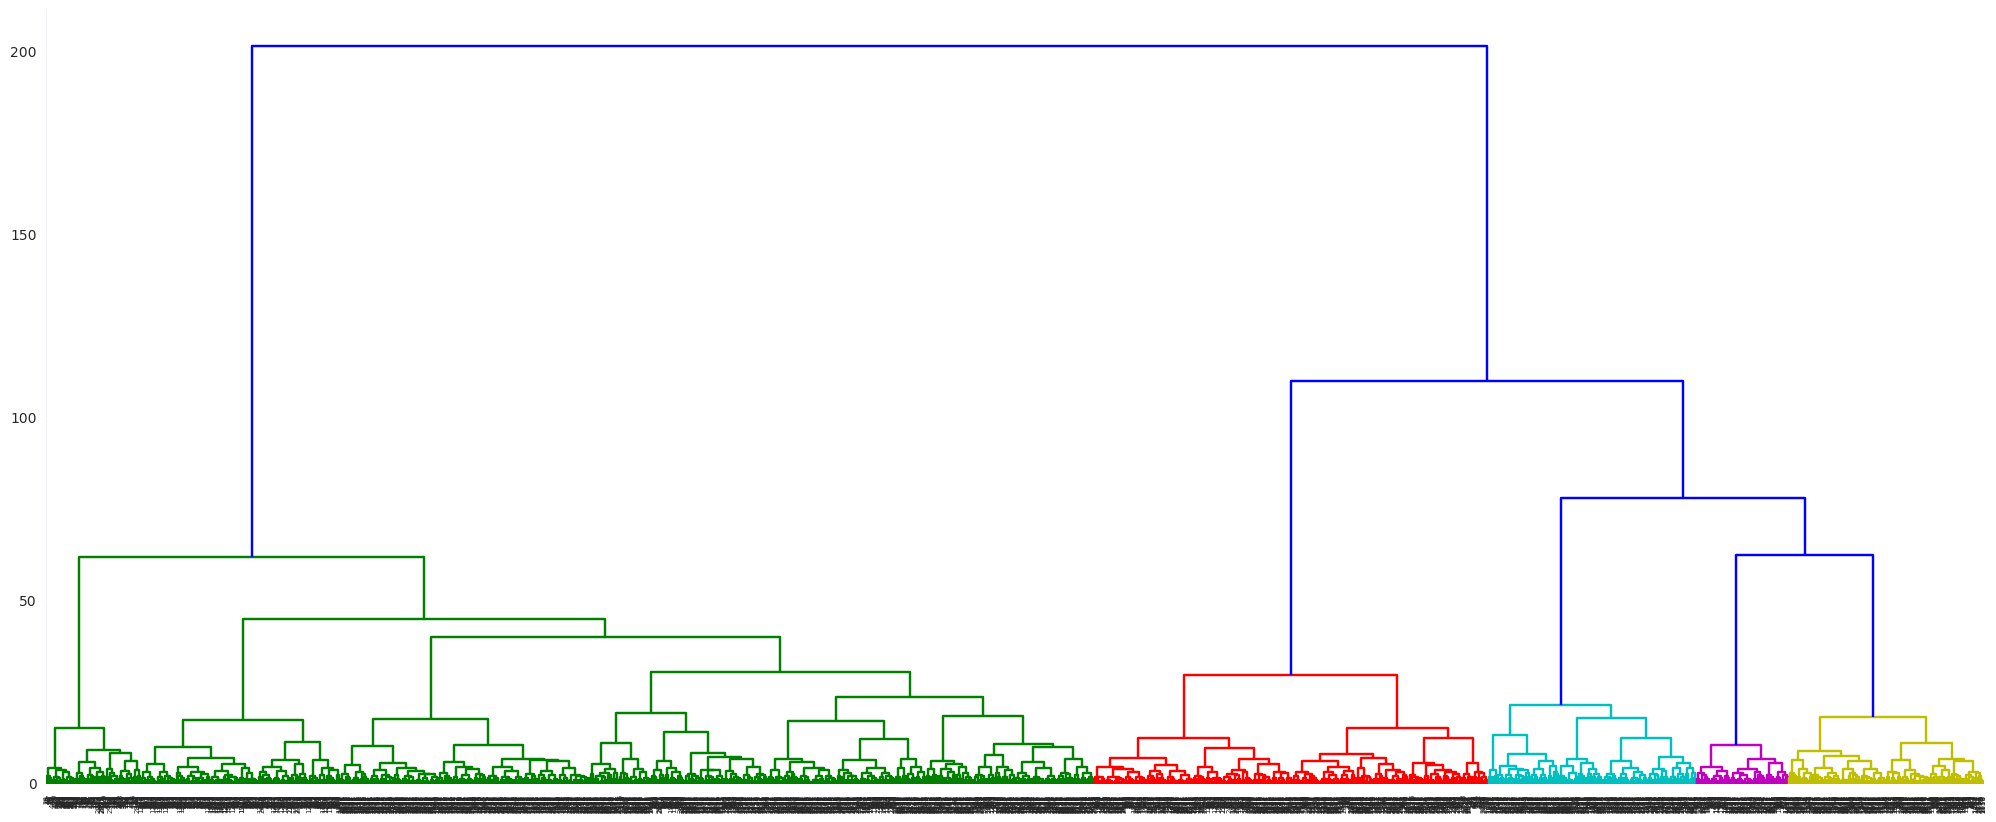

In [15]:
# plot the dendrogram colored by a certain height
hcut = 62.5
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_all,
                        color_threshold=hcut,
                        leaf_rotation=90)

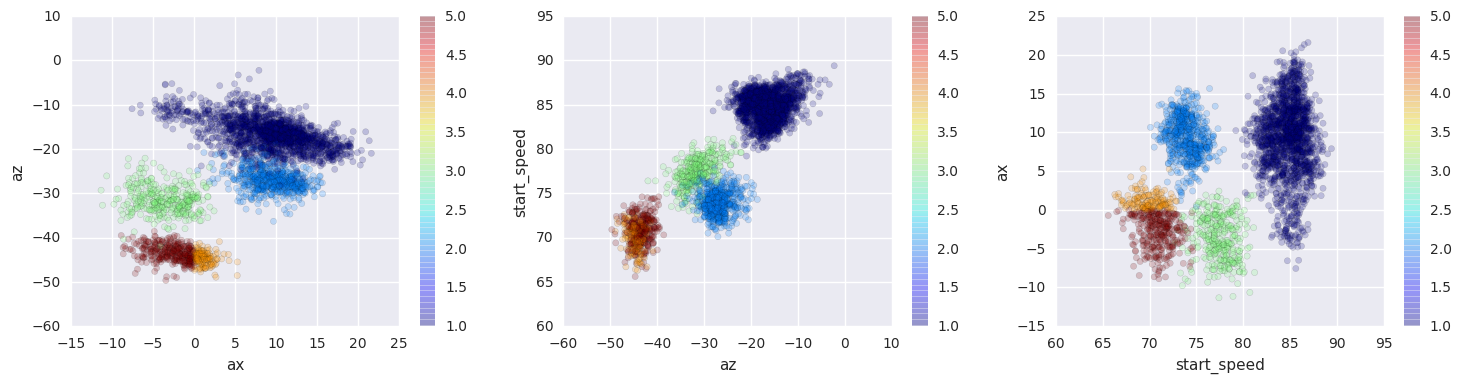

In [16]:
# labels
hlabel_all = hier.fcluster(hclust_all, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_all)

We can see that when using all features, we acutally get some clear clusters. However, when trying to distinguish a fifth cluster, we see that the curveball cluster (red) is actually spilt into two clusters. Compared to the labels from the dataset and the clustering results using our intuition, it is unlikely that this particular cluster should be split in two.

We are likely being plagued by the curse of dimensionality, where data points become more spread out in higher dimensions and appear "less similar" to each other. Thus, any clustering algorithm based on a distance metric will be negatively impacted, as it will be less clear how to group observations together.

### Based on PCA space 

Next, instead of throwing all the features into a clustering algorith, we will look to reduce the number of dimensions in the data first. This is because we want to avoid the curse of dimensionality, which we saw in action in the previous section.

We will use PCA to find a lower-dimensional representation of the data that explains as much of the variance as possible. PCA should also allow us to get around the problems from using highly-correlated features.

In [17]:
# import pca
from sklearn.decomposition import PCA

# standardize features
bz_pfxc_stand = (bz_pfxc.iloc[:, :-1]-bz_pfxc.iloc[:, :-1].mean())/bz_pfxc.iloc[:, :-1].std()

# initialize and perform pca
pca = PCA(whiten=False)
bz_pfxc_pca = pca.fit(bz_pfxc_stand)

Let's take a look of the proportion of variance explained by each principal component.

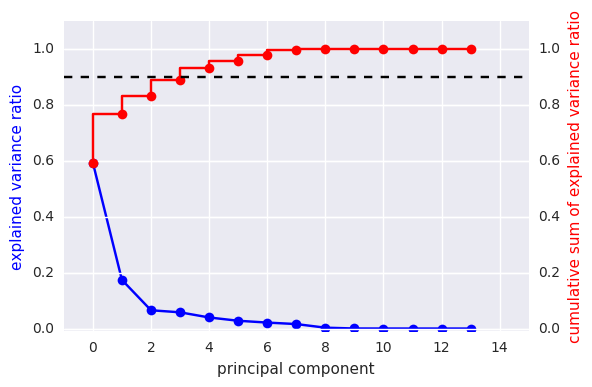

In [18]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(bz_pfxc_pca.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(bz_pfxc_pca.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 15])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

We see that the first two principal components already account for more than 75% of the variance in the data. Starting from the third principal component, there is a steep dropoff in the proportion of variance explained.

Let's now take a look at the loadings of the first four principal components to get a sense of which features they are most sensitive to.

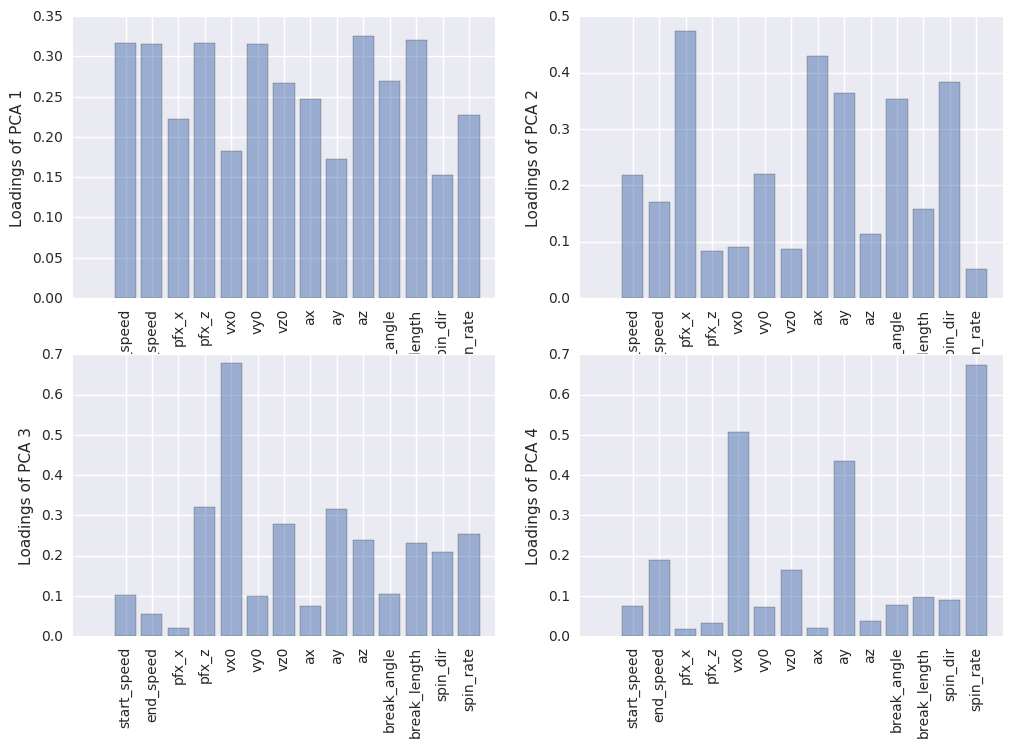

In [19]:
# intialize figure
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# plot loadings
for ii in range(2):
    for jj in range(2):
        loadings = bz_pfxc_pca.components_[2*ii+jj, :]
        # plot barchart of loadings
        ax[ii, jj].bar(range(len(loadings)), np.abs(loadings), align='center', alpha=0.5)
        ax[ii, jj].set_ylabel("Loadings of PCA %s" %(2*ii+jj+1))
        plt.sca(ax[ii, jj])
        plt.xticks(range(len(loadings)), list(bz_pfxc), rotation=90)
plt.show()

The first principal component is a measurement of mostly the velocity and vertical movement, the second is a measurement of primarily the horizontal movement, the third is a measurement of the horizontal velocity, and the fourth is a measurement of the spin rate.

We will perform hierarchical clustering using just the information from the first four principal components, so that nearly 90% of the variance in the data is explained.

In [20]:
# calculate the scores
bz_pfxc_pca_fit = np.dot(bz_pfxc_stand, bz_pfxc_pca.components_.T)

# scale the scores
bz_pfxc_pca_stand = (bz_pfxc_pca_fit-bz_pfxc_pca_fit.mean(axis=0))/bz_pfxc_pca_fit.std(axis=0)

In [21]:
# perform clustering on first four principal components
hclust_pc4 = hier.linkage(bz_pfxc_pca_stand[:, :4],
                          method='ward',
                          metric='euclidean')

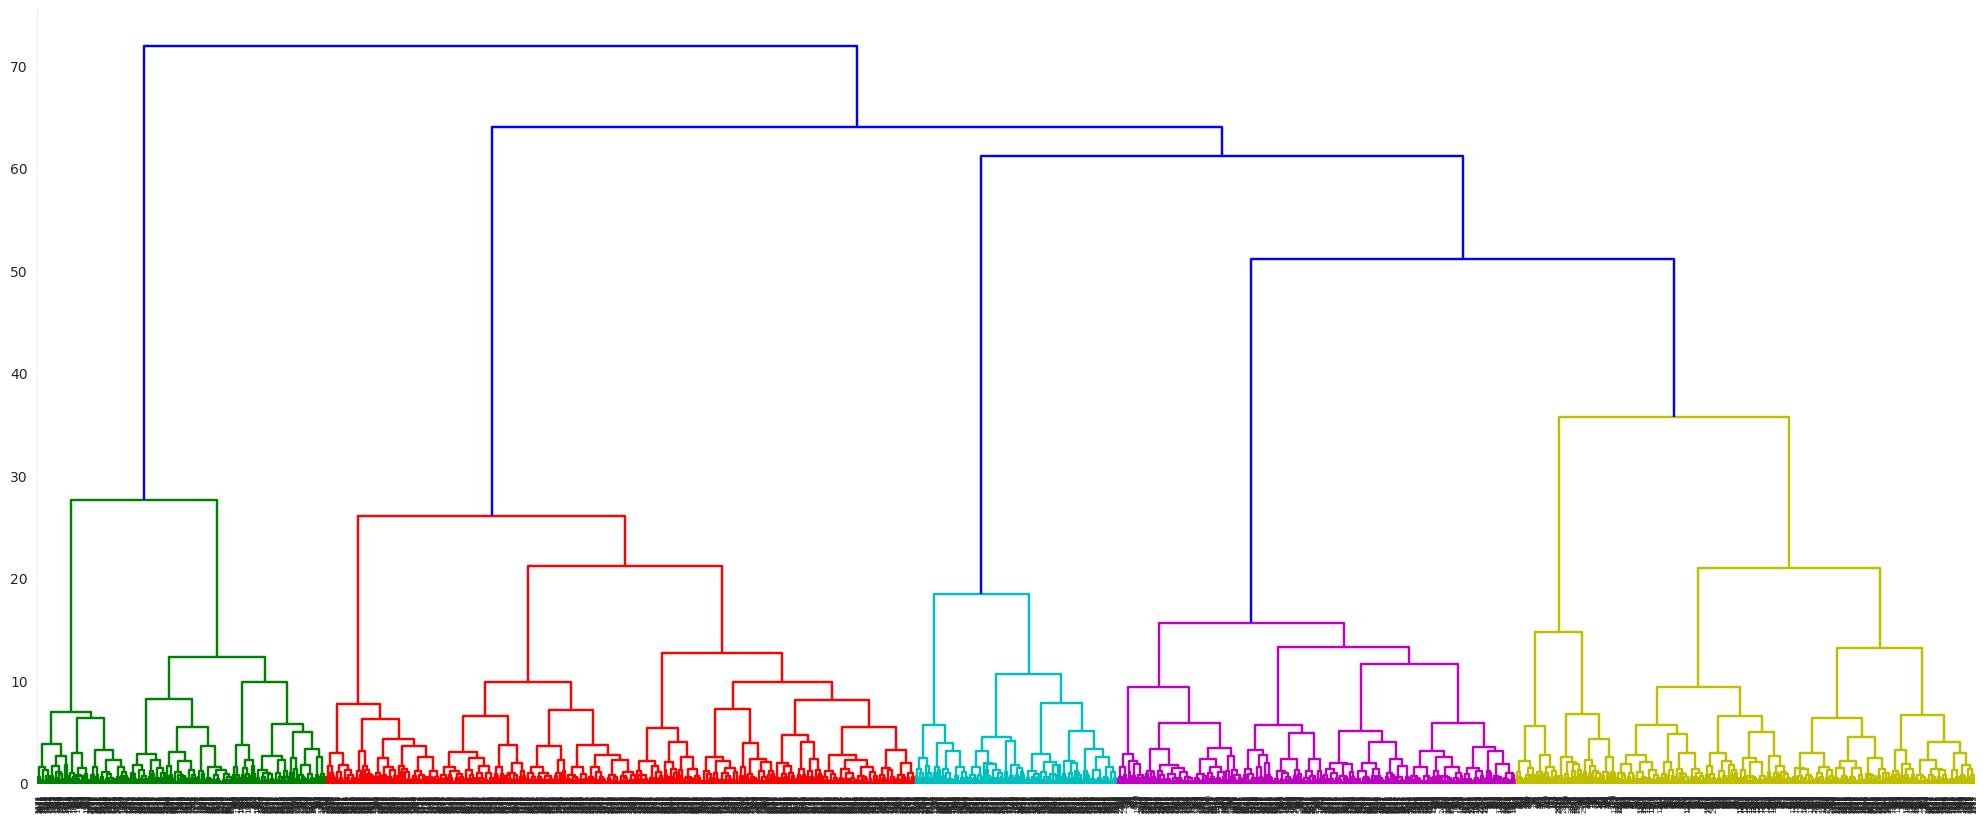

In [22]:
# plot the dendrogram colored by a certain height
hcut = 45
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_pc4,
                        color_threshold=hcut,
                        leaf_rotation=90)

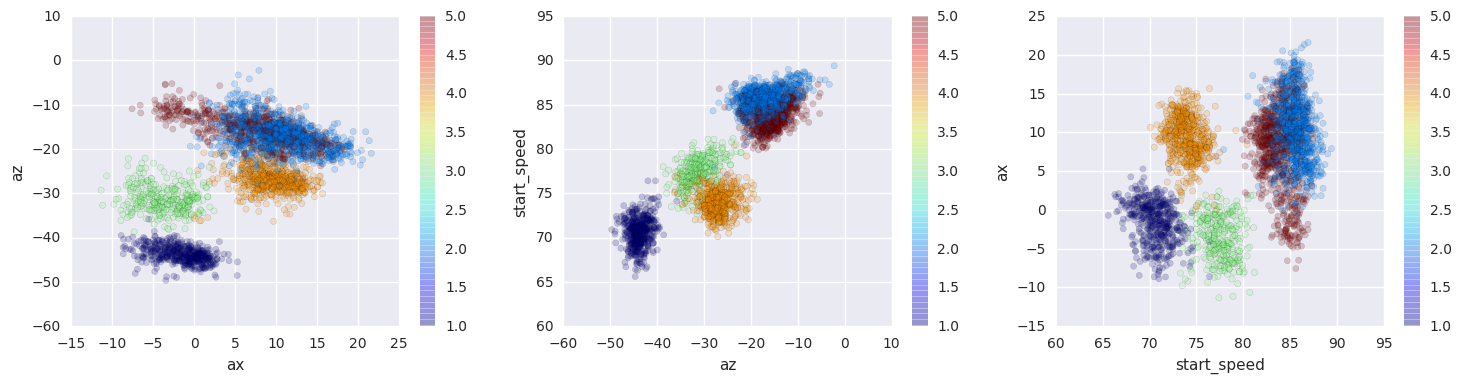

In [23]:
# get cluster labels
hlabel_pc4 = hier.fcluster(hclust_pc4, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_pc4)

We see that our clustering results in PCA space do a relatively good job finding five clusters. They appear to be the clusters related to the four-seamer, two-seamer, changeup, slider, and curveball. These are similar results when using our intution for selecting clustering features, although there is some difference in the ratio of four-seamers and two-seamers. Overall, it seems that PCA can be effective in reducing the dimension of our data for clustering purposes.

Let's look at how the clustering looks when using three principal components.

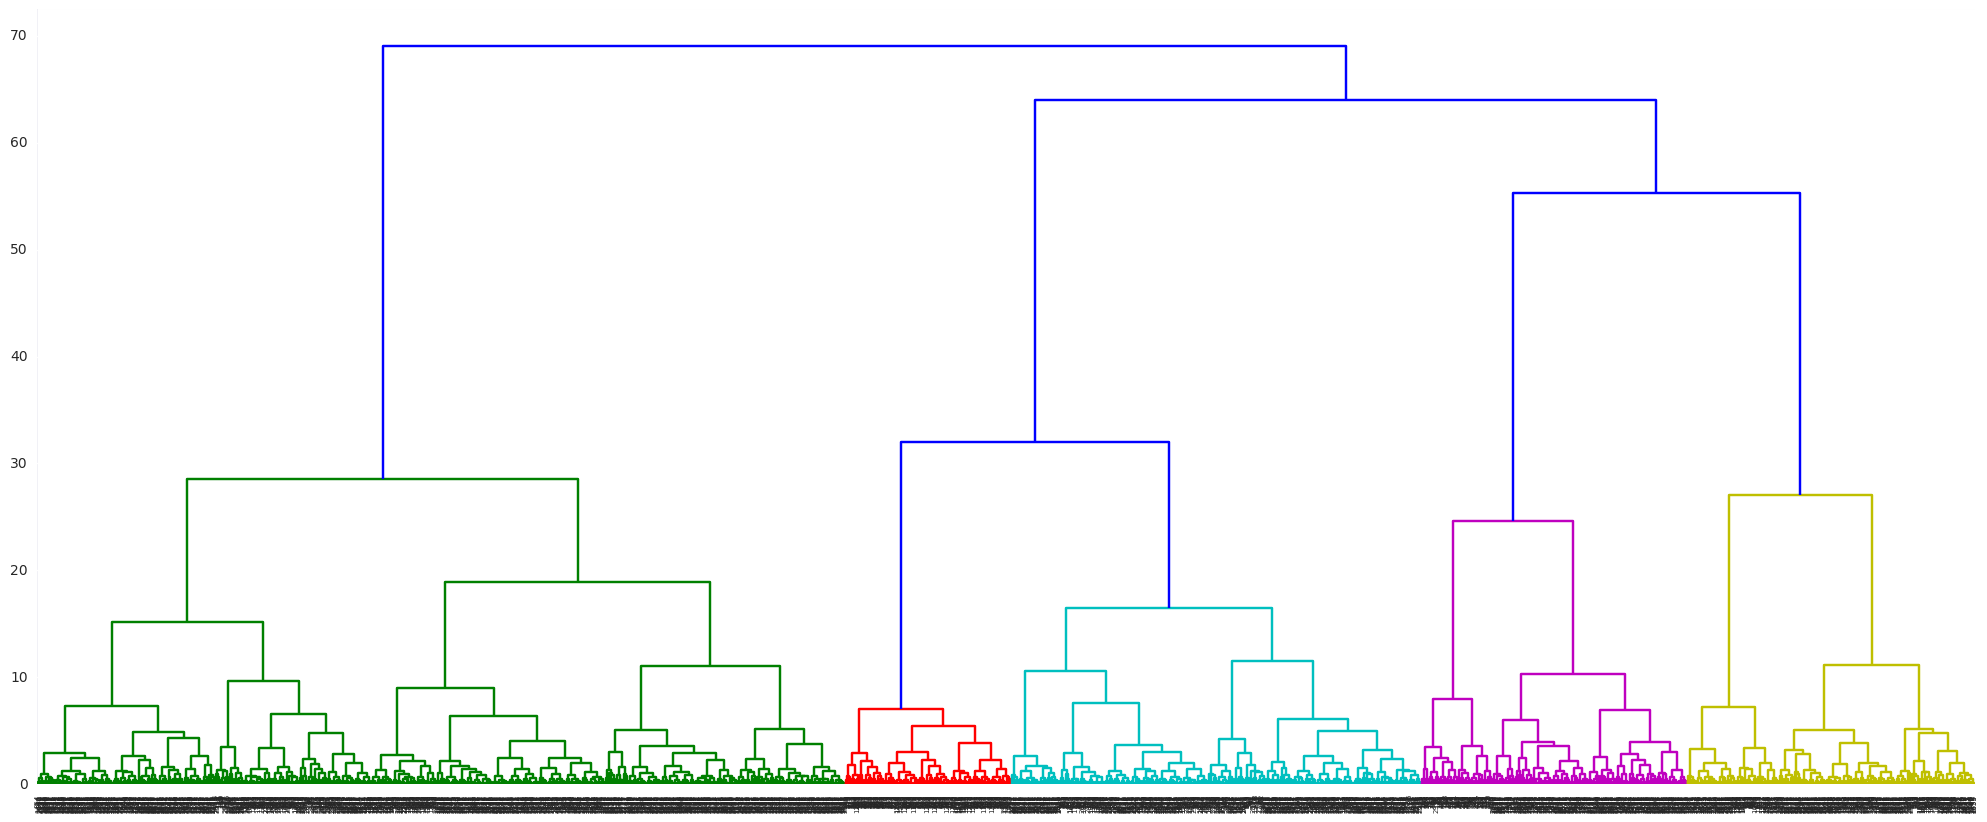

In [24]:
# perform clustering on first four principal components
hclust_pc3 = hier.linkage(bz_pfxc_pca_stand[:, :3],
                          method='ward',
                          metric='euclidean')

# plot the dendrogram colored by a certain height
hcut = 30
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_pc3,
                        color_threshold=hcut,
                        leaf_rotation=90)

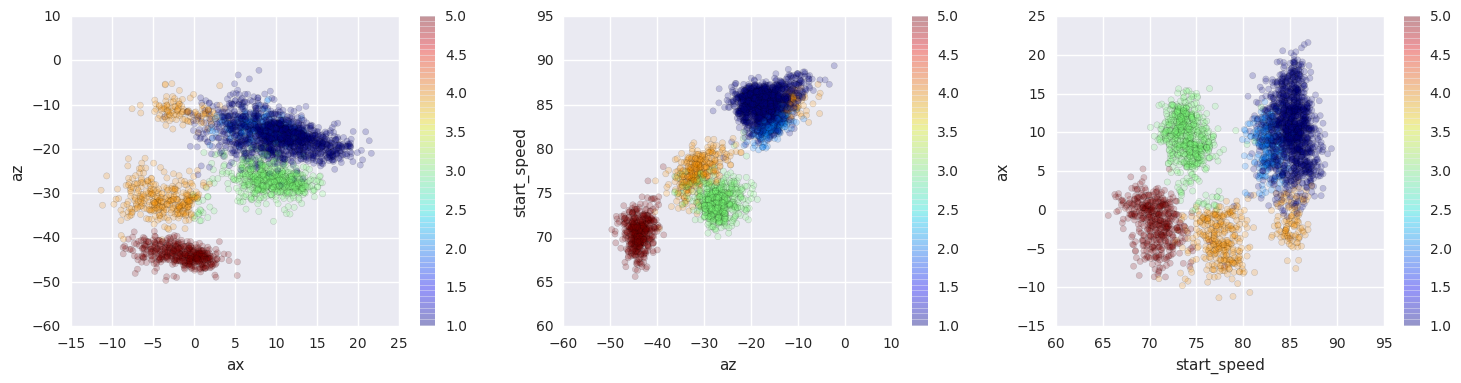

In [25]:
# get cluster labels
hlabel_pc3 = hier.fcluster(hclust_pc3, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_pc3)

We see that when we use three principal components, the five clusters are less convincing than when using four principal components. We can see the red cluster is split, and the orange cluster is hidden in the largest cluster.

Thus, we see that the quality of the clustering appears to be dependent on the number of principal components used in the analysis. While fewer principal components lead to data points being more condensed (and hence easier to cluster), less of the variance in the data is explained. On the other hand, while more principal components describe more variance in the data, the data points are more spread out (and hence less meaningful when clustered).

Overall, we see that using all trajectory features for classifying pitch types can be harmful to the clustering results. We can use PCA to decorrelate features and avoid the curse of dimensionality, but PCA tries to explain the variance of the data in a lower dimension, not help separate clusters in our data. While clustering in principal-component space can lead to reasonable clusters, the quality of the clustering appears highly dependent on the number of principal components kept. Thus, for the particular case of pitch classification, it appears best to cluster pitches using features based on our intuition (velocity and vertical/horizontal movements).

## Comparison of pitch classifications

Let's compare the pitch classification counts from the database labels, cluster labels using intuitive features, and cluster labels after PCA. We'll group them by perceived pitch type.

In [26]:
# label counts from database
pcount_database = bz_pfxc["pitch_type"].value_counts()

To deal with the results from clustering, we'll manually convert cluster labels from numbers to pitch type based on what we see our crossplots and prior knowledge of generally pitch trajectory.

In [27]:
# label counts from intuition
count_intuit5 = np.bincount(hlabel_intuit5)
dcount_intuit5 = {"FT": count_intuit5[1],
                  "FF": count_intuit5[2],
                  "CH": count_intuit5[3],
                  "SL": count_intuit5[4],
                  "CU": count_intuit5[5]}

# label counts from pca
count_pc4 = np.bincount(hlabel_pc4)
dcount_pc4 = {"FT": count_pc4[2],
              "FF": count_pc4[5],
              "CH": count_pc4[4],
              "SL": count_pc4[3],
              "CU": count_pc4[1]} 

# convert dictionary to dataframe
pclass = pd.DataFrame([dcount_intuit5, dcount_pc4],
                       index=["intuition", "pca"])

# combine database classifications and clutering labels
pclass = pclass.append(pcount_database).fillna(0)

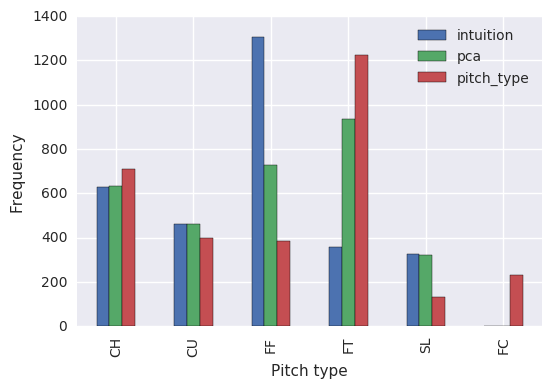

In [28]:
# plot comparitive bar chart of pitch counts
pclass.transpose().plot.bar()
plt.xlabel("Pitch type")
plt.ylabel("Frequency")
plt.show()

The number of each type of pitch is fairly similar across all three classification methods (database, intuitive features, PCA space). The major difference is that the database labels contain 7 pitch classifications, with the addition of a cut fastball being the most significant. However, we saw from crossplotting the database labels that some of the cutters appeared to be incorrectly grouped with sliders (which explains why the slider count is smaller in the database than from clustering).

Furthermore, our clustering methods are classifying only slightly more two-seamers than four-seamers, while the database labels are classifying significantly more two-seamers than four-seamers. Let's combine all fastballs (four-seamer, two-seamer, and cutter) into one fastball category and compare the counts again.

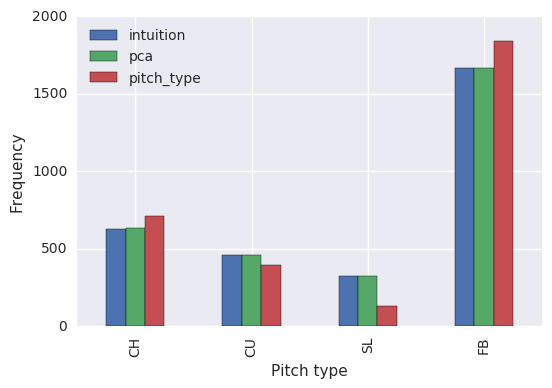

In [29]:
# combine columns
pclass["FB"] = pclass["FF"]+pclass["FC"]+pclass["FT"]

# create new dataframe for plotting
pclass_mod = pclass.drop(["FC",
                          "FT",
                          "FF"], 1)

# plot comparitive bar chart of pitch counts
pclass_mod.transpose().plot.bar()
plt.xlabel("Pitch type")
plt.ylabel("Frequency")
plt.show()

We see that when we combine all fastballs into one category (`FB`), the pitch type distributions are similar. The difference in fastball counts from the database and the clustering results can be attributed to some cut-fastballs being classified as sliders in the database.

Moving forward, we will use the velocity and vertical/horizontal movements as our features for labeling our pitch types. Because different types of fastballs (cutter, two-seam, four-seam) are difficult to reliably distinguish, we'll group them all into one category. While PCA helps to project our data in a lower-dimensional space, the number of principcal components to keep in our clustering methods needs to potentially be tuned for every pitcher.

Of course, every pitcher has a different set of pitches at his disposal. So while Barry Zito has arguably 5 different pitches, others will have more or less. Hierarchical clustering is useful when exploring the data for clusters of pitches, but it is difficult to automate what the cut-off height should be. Therefore, we will look into a different set of clustering approaches and run them in parallel.

### DBSCAN with K-means clustering

Density-based spatial clustering of applications with noise (DBSCAN) groups together data observations that are close together. This approach has the advantages that, the number of clusters beforehand does not need to be known, it is robust to outliers (or noise features that are not truly associated with the response), and can find arbitrarily shaped clusters. Therefore, this is a reasonable approach for determining the number of clusters when it is not known apriori.

In our case of pitch classification, we'd like every pitch to have a label. DBSCAN finds clusters but will also label outliers. We'd like those outliers to also have labels as pitch types. Therefore, we will run one iteration of K-means clustering using centroids estimated from the results of K-means clustering.

#### DBSCAN

This particular clustering method proceeds as follows:

1) Make an n-dimensional sphere of radius epsilon around the point and count the number of data points within the sphere.

2) If the number of points within the sphere are more than *min_points* then we mark the center of the sphere to be belonging to a cluster. We also mark the points inside the sphere to be belonging to the same cluster. We then recursively expand the cluster by applying the same criteria to the points inside the sphere, except the center.

3) In case the number of points inside the sphere are less than min_points, we ignore it and proceed to the next point in the dataset.

There are three primary parameters for this method. First, there is a distance metric, which we take to be Euclidean distance. Second, there is the minimum number of data points within a region needed to create a dense cluster (`min_points`). A rule of thumb is that this value should be at least twice the dimension of the data set. Here, we will take it to be five times the dimension of the data set, as larger values tend to lead to more significant clusters. Third, there is the maximum distance between two samples for data observations to be considered as in the same neighborhood (`eps`). This value can be estimated from looking for an elbow point on a K-distance plot (i.e., sorted distances between each data point and its `min_points`-th nearest neighbor).

In [280]:
# imports
from sklearn.neighbors import NearestNeighbors

# standardize intuitive features
pitches_intuit_stand = (pitches_intuit-pitches_intuit.mean())/pitches_intuit.std()

# set min_points parameter
min_points = 5*pitches_intuit_stand.shape[1]

# initialize nearest-neighbor object
nbrs = NearestNeighbors(n_neighbors=min_points,
                        metric="euclidean")

# fit nearest-neighbors
nbrs_fit = nbrs.fit(pitches_intuit_stand)
kdist, kind = nbrs_fit.kneighbors(pitches_intuit_stand)

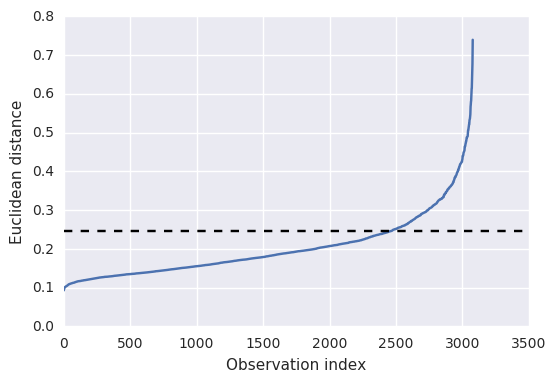

In [281]:
# get distances and sort
kk = np.sort(kdist[:, -1])

# set percentile cutoff
q = 80

# plot sorted distance as a function of data point index
plt.plot(kk)
plt.xlabel("Observation index")
plt.ylabel("Euclidean distance")
plt.axhline(y=np.percentile(kk, q=q),
            color='k',
            ls='dashed',)
plt.show()

Typically, we calculate the maximum distance between samples (`eps`) as the 'elbow' of the sorted distances for the `min_points`-th nearest neighbors. In the previous plot, we added a horizontal line representing the 80th percentile of distances. We'll pick the `eps` value to be the 80th percentile of distances for now and run DBSCAN with Euclidean distance as our metric.

In [32]:
# initialize variables
from sklearn.cluster import DBSCAN
eps = np.percentile(kk, q=q)

# initialize dbscan object
dbscan = DBSCAN(eps=eps,
                min_samples=min_points,
                metric="euclidean",)

# fit and predict labels with dbscan
label_dbscan = dbscan.fit_predict(pitches_intuit_stand)

Let's look at the initial cluster labels from DBSCAN in feature space.

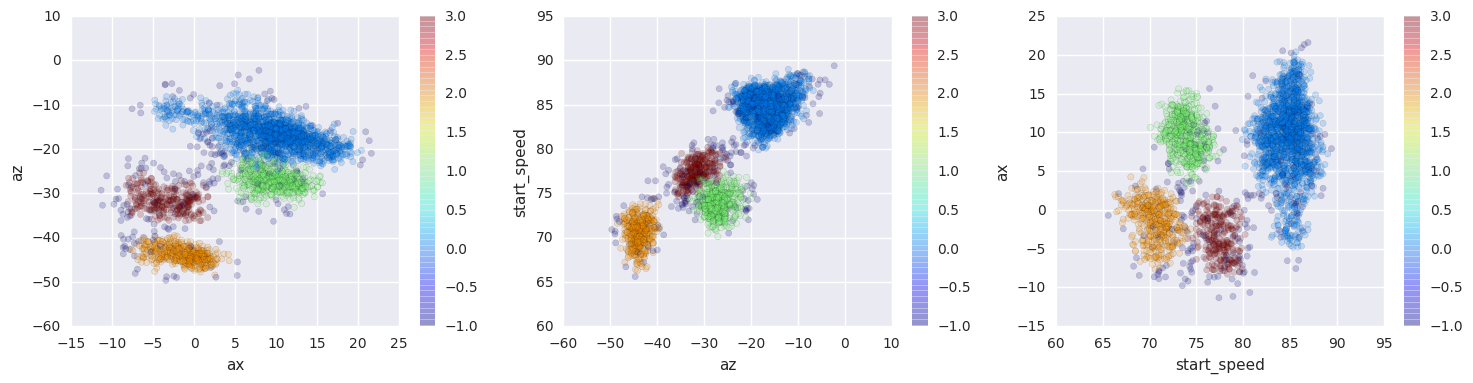

In [33]:
# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", label_dbscan)

We can see that there are four distinct clusters that actually correspond well with the clusters we obtained with hierarchical clustering. We can easily pick out the fastball (blue), changeup (green), slider (red), and curveball (orange) clusters. However, there are a number of outliers that are not labeled. Since we would like to label all pitches, we will use the number of clusters from the DBSCAN result and the corresponding cluster centroids as a starting point for K-means clustering.

#### K-means clustering

K-means clustering is an interative clustering process that estimates a label for all data points. Its procedure has the following steps.

1) Assign K data points randomly to be starting centroids (where K is the number of clusters desired)

2) Assign the remaining data points to those centroids based on a chosen distance metric.

3) Calculate the new cluster centroid locations based on the mean locations of the data points assigned to each respective cluster.

4) Repeat steps 1-3 until the centroid locations don't change or until a maximum number of iterations is run.

Two issues with K-means clustering is that the user must decide the number of clusters beforehand, and that the algorithm's solution can fall into a local minimum. However, using DBSCAN beforehand solves both of these problems, as we already have the number of clusters and ideal starting cluster centroids. We will one run iteration of K-means clustering to label the outliers.

In [34]:
# create labeled dataframe
bz_pfxc_stand_labeled = pd.concat([pitches_intuit_stand.reset_index(drop=True),
                                   pd.Series(label_dbscan, name="ptype")],
                                   axis=1)

# calculate centroids and number of clusters
centroids_init = bz_pfxc_stand_labeled.groupby("ptype").mean().iloc[1:, :]
k = centroids_init.shape[0]

In [35]:
# import package
from sklearn.cluster import KMeans

# perform K-means
label_kmeans = KMeans(n_clusters=k,
                      init=centroids_init,
                      n_init=1).fit_predict(pitches_intuit_stand)

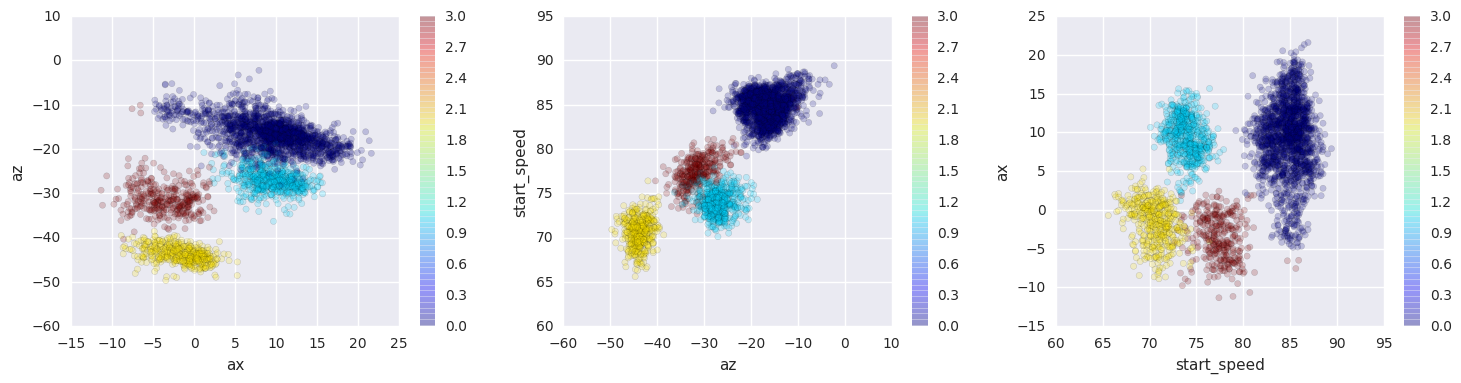

In [36]:
# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", label_kmeans)

Thus, we see that we have labeled all the pitches, including the outliers from DBSCAN. We can see that the outliers are now labeled but with lower confidence than the points labeled from DBSCAN. However, this appears to be one way to cluster pitches automatically when the number of pitch types is unknown.

Let's look at how our automatic pitch clustering labels compare to those from the other clusterings we've done in this analysis.

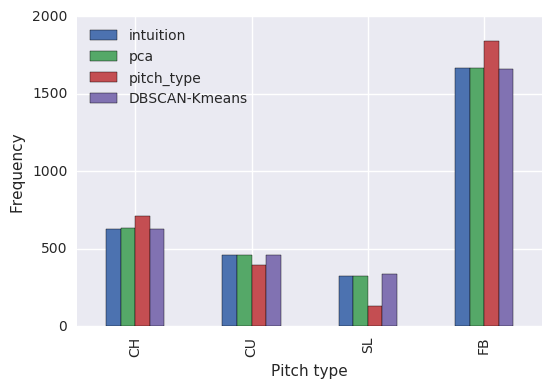

In [37]:
# label counts from DBSCAN+Kmeans
count_dbk = np.bincount(label_kmeans)
dcount_dbk = {"FB": count_dbk[0],
              "CU": count_dbk[2],
              "CH": count_dbk[1],
              "SL": count_dbk[3],}

# create dataframe of counts
pclass_mod2 = pclass_mod.append(pd.Series(dcount_dbk, name="DBSCAN-Kmeans")).fillna(0)

# plot comparitive bar chart of pitch counts
pclass_mod2.transpose().plot.bar()
plt.xlabel("Pitch type")
plt.ylabel("Frequency")
plt.show()

Results are relatively similar to the clustering labels from intutive features and after PCA across the methods.

Let's look at another pitcher, Roy Halladay, and see how the pitch classifications in the database compares to our automatic approach.

In [325]:
# imports
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

class dbscan_kmeans():
    """Class to perform DBSCAN and Kmeans in series"""
    def __init__(self, **params):
        """Initialize variables
        
        Inputs:
            scale [0]: value to scale dimension d of data for min_points estimate in DBSCAN
                       default 0 means scale by number of samples divided by 500
            q [80]: quantile (percent) of k-nearest-neighbor for eps estimate in DBSCAN
        """
        # default parameters
        self.scale = 0
        self.q = 80
        
        if params:
            if "q" in params:
                self.q = params["q"]
            if "scale" in params:
                self.scale = params["scale"]
        
    def fit(self, X, **stand):
        """Fit dbscan parameters to data
        
        Inputs:
            X: dataframe (n_data, n_features)
            stand [False]: to standardize data or not (optional)
            plot [False]: to plot k nearest-neighbor graph or not (optional)
            
        Outputs:
            eps: esp parameter for dbscan
            min_points: min_points parameter for dbscan
        """
        # pass variable
        self.X = X
        
        # standardize features
        if stand:
            if "stand" in stand:
                if bool(stand["stand"]):
                    self.X = (self.X-self.X.mean(axis=0))/self.X.std(axis=0)
        
        # set min_points parameter
        self.min_points = self.scale*self.X.shape[1]

        # initialize nearest-neighbor object
        nbrs = NearestNeighbors(n_neighbors=self.min_points,
                                metric="euclidean")
        
        # fit nearest-neighbors
        nbrs_fit = nbrs.fit(self.X)
        self.kdist, self.kind = nbrs_fit.kneighbors(self.X)
        
        # estimate eps paramter
        self.eps = np.percentile(self.kdist[:, -1], q=self.q)
        
        # optional plot
        if stand:
            if "plot" in stand:
                if bool(stand["plot"]):
                    self.plot_knn()
                    
        # clean up
        return self.eps, self.min_points
                    
    def fit_predict(self, X, **stand):
        """Fit dbscan parameters to data
        
        Inputs:
            X: dataframe (n_data, n_features)
            stand [False]: to standardize data or not (optional)
            plot [False]: to plot k nearest-neighbor graph or not (optional)
            
        Output:
            label_kmeans: labeled pitches
        """
         # pass variable
        self.X = X
        if self.scale==0:
            self.scale = np.rint(self.X.shape[0]/500)
        
        # standardize features
        if stand:
            if "stand" in stand:
                if bool(stand["stand"]):
                    self.X = (self.X-self.X.mean(axis=0))/self.X.std(axis=0)
        
        # set min_points parameter
        self.min_points = int(self.scale*self.X.shape[1])

        # initialize nearest-neighbor object
        nbrs = NearestNeighbors(n_neighbors=self.min_points,
                                metric="euclidean")
        
        # fit nearest-neighbors
        nbrs_fit = nbrs.fit(self.X)
        self.kdist, self.kind = nbrs_fit.kneighbors(self.X)
        
        # estimate eps paramter
        self.eps = np.percentile(self.kdist[:, -1], q=self.q)
        
        # initialize dbscan object
        dbscan = DBSCAN(eps=self.eps,
                        min_samples=self.min_points,
                        metric="euclidean",)
        
        # fit and predict labels with dbscan
        self.label_dbscan = dbscan.fit_predict(self.X)

        # use pandas to calculate centroids
        self.X_grouped = pd.concat([self.X.reset_index(drop=True),
                                    pd.Series(self.label_dbscan, name="ptype")],
                                    axis=1)

        # calculate centroids and number of clusters
        self.centroids_init = self.X_grouped.groupby("ptype").mean().iloc[1:, :]
        self.k = self.centroids_init.shape[0]
        
        # perform K-means
        self.label_kmeans = KMeans(n_clusters=self.k,
                                   init=self.centroids_init,
                                   n_init=1).fit_predict(self.X)

        # clean up
        return self.label_kmeans
        
    def plot_knn(self):
        """Return plot of sorted distances for a given K nearest neighbor"""     
        # sort distances for plotting
        kk = np.sort(self.kdist[:, -1])

        # plot sorted distance as a function of data point index
        plt.plot(kk)
        plt.xlabel("Observation index")
        plt.ylabel("Euclidean distance")
        plt.axhline(y=np.percentile(kk, q=self.q),
                    color='k',
                    ls='dashed',)
        plt.show()

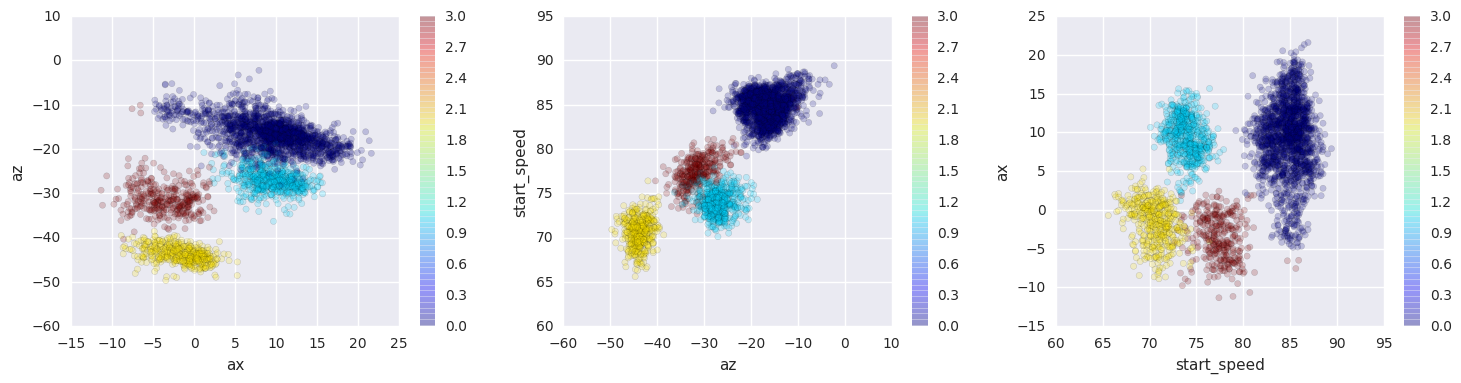

In [327]:
dbk = dbscan_kmeans(scale=5, q=80)
ll = dbk.fit_predict(pitches_intuit, stand=1)
#dbk.plot_knn(qplt=80)
xplot3(bz_pfxc, "ax", "az", "start_speed", ll)

In [100]:
# grab pitches
query = """SELECT DISTINCT pitchfx.* 
    FROM pitchfx
    JOIN events ON (pitchfx.game_id=events.game_id
        AND pitchfx.prev_event=events.event_id)
    WHERE events.pitcher_id=(SELECT player_id
        FROM players
        WHERE players.player_first='Dan'
            AND players.player_last='Haren')
    ORDER BY game_id, pitch_num"""
rh_pfx = pd.read_sql_query(query, db)

In [101]:
# drop nans, pitch-outs, and intential balls
rh_pfx = rh_pfx.dropna(axis=0, how="any")
rh_pfx = rh_pfx[rh_pfx.pitch_type!="IN"]
rh_pfx = rh_pfx[rh_pfx.pitch_type!="PO"]

# grab intuitive features
rh_pfx_intuit = rh_pfx[["ax",
                        "az",
                        "start_speed",]]

# standardize features
rh_pfx_intuit_stand = (rh_pfx_intuit-rh_pfx_intuit.mean())/rh_pfx_intuit.std()
#rh_pfx_intuit_stand["ax"] = 4*rh_pfx_intuit_stand["ax"]
#rh_pfx_intuit_stand["start_speed"] = 4*rh_pfx_intuit_stand["start_speed"]
#rh_pfx_intuit_stand = rh_pfx_intuit-rh_pfx_intuit.mean()

In [92]:
# run dbscan and kmeans
# set min_points parameter
scale = max(5, np.rint(rh_pfx_intuit_stand.shape[0]/500))
min_points = int(scale*rh_pfx_intuit_stand.shape[1])

# initialize nearest-neighbor object
nbrs = NearestNeighbors(n_neighbors=min_points,
                        metric="euclidean")

# fit nearest-neighbors
nbrs_fit = nbrs.fit(rh_pfx_intuit_stand)
kdist, kind = nbrs_fit.kneighbors(rh_pfx_intuit_stand)

# get distances and sort
kk = np.sort(kdist[:, -1])

# set percentile cutoff
q = 70

# initialize variables
eps = np.percentile(kk, q=q)

# initialize dbscan object
dbscan = DBSCAN(eps=eps,
                min_samples=min_points,
                metric="euclidean",)

# fit and predict labels with dbscan
label_dbscan = dbscan.fit_predict(rh_pfx_intuit_stand)

# perform K-means
label_kmeans = KMeans(n_clusters=6, random_state=0, n_init=100).fit_predict(rh_pfx_intuit_stand)

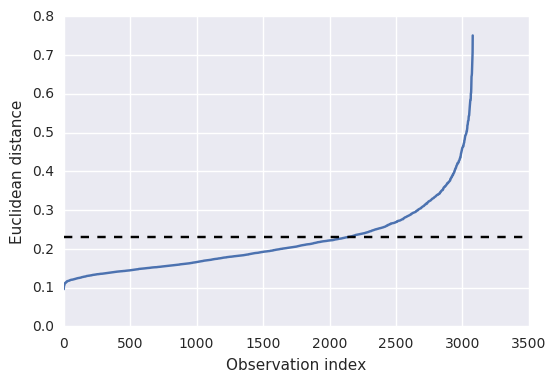

In [60]:
# plot sorted distance as a function of data point index
plt.plot(kk)
plt.xlabel("Observation index")
plt.ylabel("Euclidean distance")
plt.axhline(y=np.percentile(kk, q=q),
            color='k',
            ls='dashed',)
plt.show()

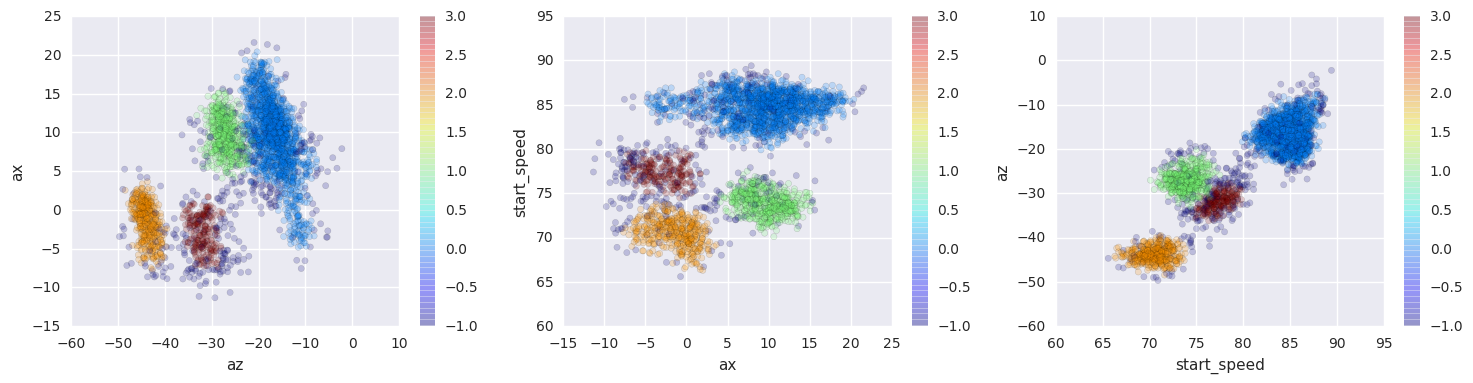

In [61]:
# plot
xplot3(rh_pfx, "az", "ax", "start_speed", label_dbscan)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


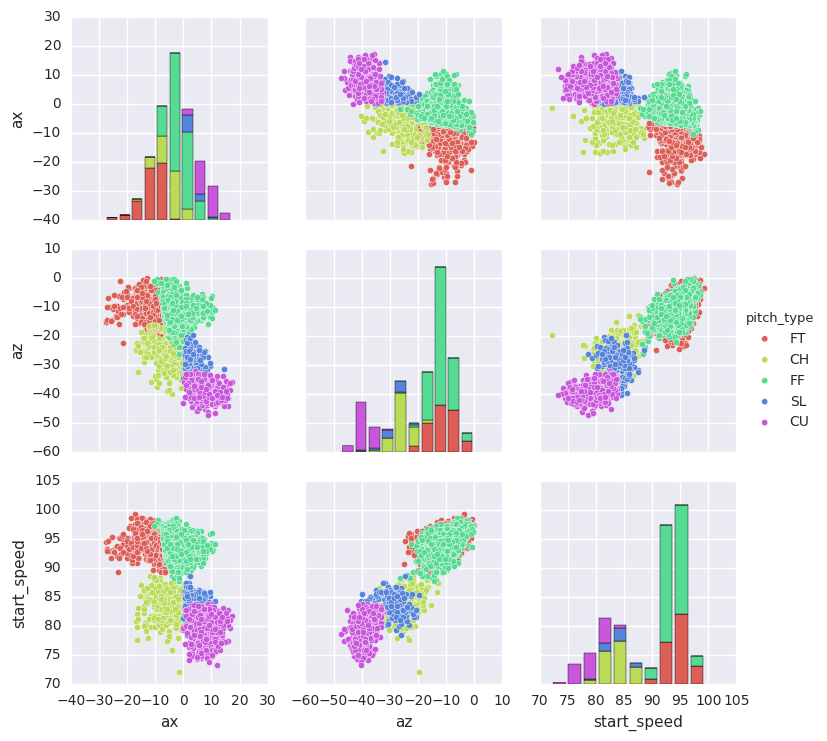

In [43]:
# pitch type from database
rh_pfx_intuit["pitch_type"] = rh_pfx["pitch_type"]
sns.pairplot(data=rh_pfx_intuit,
             hue="pitch_type",
             palette="hls")
plt.show()

Therefore, we will look to classify pitches into fastball and detailed off-speed and breaking pitches using our automatic DBSCAN and K-means clustering approach.

In [44]:
rh_pfx_intuit_stand.std()

ax             1.0
az             1.0
start_speed    1.0
dtype: float64

In [45]:
rh_pfx_intuit_stand.shape[0]/500

6.9

In [46]:
rh_pfx_intuit_stand.shape[0]/1000

3.45

In [206]:
import sys
from sklearn.neighbors import NearestNeighbors
sys.setrecursionlimit(10000)

class multi_dbscan():
    """Multi-density DBSCAN
    
    Algorithm to discover clusters with different densities.
    Based on "Multi Density DBSCAN", Wesam and Saad, 2011.
    """
    def __init__(self, k, var):
        """Initialize multi_dbscan object
        
        Inputs:
            k: number of nearest neighbors
            var: variance, greater than 1
        """
        self.k = k
        self.var = var
        
    def fit_predict(self, X):
        """Fit multi-dbscan and predict labels
        
        Inputs:
            X: standardized data points [n_observations, n_features]
        """
        # pass input
        self.X = X
        
        # find K nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=self.k,
                                metric="euclidean")
        nbrs_fit = nbrs.fit(X)
        self.k_dist, self.k_ind = nbrs_fit.kneighbors(X)
    
        # create average distance of k nearest neighbors for each point
        self.aDST = dict(enumerate(np.sum(self.k_dist, axis=1)/(self.k-1)))

        # initialize cluster at densest point
        self.clusters = {}
        self.nclust = 0
        while self.aDST:
            idat = min(self.aDST, key=self.aDST.get)
            self.clusters[self.nclust] = [idat]
            self.cluster_aDST = self.aDST[idat]
            self.aDST.pop(idat, None)
            self.cluster_expand(idat)
            if len(self.clusters[self.nclust])<20:
                self.clusters.pop(self.nclust, None)
            self.nclust += 1
        
        # clean up
        return self.clusters

    def cluster_expand(self, idat):
        """Expand cluster recursively"""
        for qq in self.k_ind[idat, :]:
            if (qq in self.aDST) and (self.aDST[qq]<=self.var*self.cluster_aDST):
                # add index to cluster
                self.clusters[self.nclust].append(qq)
                lcluster = len(self.clusters[self.nclust])
                self.cluster_aDST = (self.cluster_aDST*(lcluster-1)+self.aDST[qq])/lcluster
                self.aDST.pop(qq, None)
                self.cluster_expand(qq)

In [48]:
mdbscan = multi_dbscan(10, 2)
dist = mdbscan.fit_predict(rh_pfx_intuit_stand)

In [49]:
for ii in dist:
    print(len(dist[ii]))

2066
1148


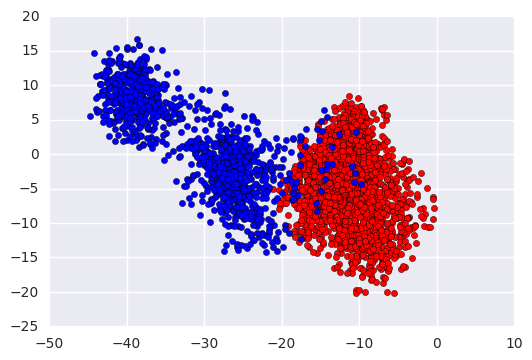

In [50]:
test = rh_pfx_intuit.reset_index(drop=True)
colors = ["red", "blue", "green", "orange", "yellow"]
ccount = 0
for ii in dist:
    plt.scatter(test["az"][dist[ii]],
                test["ax"][dist[ii]],
                c=colors[ccount],)
    ccount += 1
plt.show()

In [51]:
# create fake data in 2d
mean1 = np.array([2, 5])
cov1 = np.array([[1, 0],
                [0, 2]])
g1 = np.random.multivariate_normal(mean1, cov1, 100)

mean2 = np.array([5, -4])
cov2 = np.array([[1, 0],
                [0, 1]])
g2 = np.random.multivariate_normal(mean2, cov2, 1000)

mean3 = np.array([-2, -6])
cov3 = np.array([[1, 0],
                [0,12]])
g3 = np.random.multivariate_normal(mean3, cov3, 500)

gg = np.concatenate([g1, g2, g3])

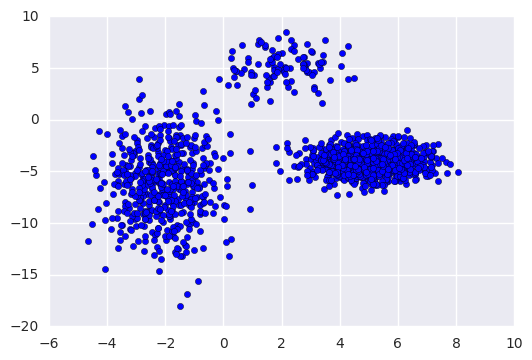

In [52]:
plt.scatter(gg[:, 0], gg[:, 1],)
plt.show()

In [53]:
gg_std = (gg-gg.mean(axis=0))/gg.std(axis=0)

In [54]:
mdbscan = multi_dbscan(10, 3)
dist = mdbscan.fit_predict(gg_std)

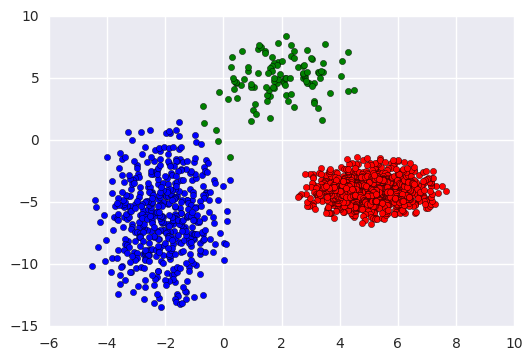

In [55]:
colors = ["red", "blue", "green", "orange", "yellow"]
ccount = 0
for ii in dist:
    plt.scatter(gg[dist[ii], 0],
                gg[dist[ii], 1],
                c=colors[ccount],)
    ccount += 1
plt.show()

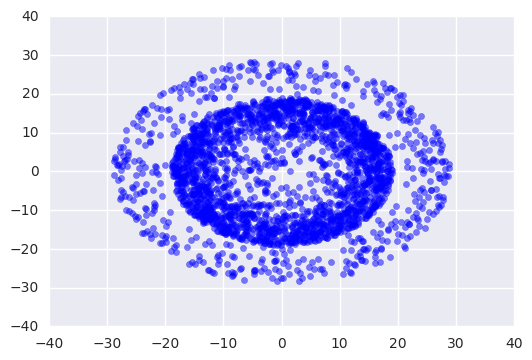

In [207]:
# create circular uniform data
radius = 10
theta = 2*np.pi*np.random.uniform(size=150)
r = radius*np.sqrt(np.random.uniform(size=150))
x1 = r*np.cos(theta)
y1 = r*np.sin(theta)

r = radius-1+radius*np.sqrt(np.random.uniform(size=2000))
theta = 2*np.pi*np.random.uniform(size=2000)
x2 = r*np.cos(theta)
y2 = r*np.sin(theta)

r = 2*radius-1+radius*np.sqrt(np.random.uniform(size=500))
theta = 2*np.pi*np.random.uniform(size=500)
x3 = r*np.cos(theta)
y3 = r*np.sin(theta)

xx = np.concatenate((x1, x2, x3))
yy = np.concatenate((y1, y2, y3))
dat = np.column_stack((xx, yy))

plt.scatter(xx, yy, color="blue", alpha=0.5)
plt.show()

In [208]:
dat_std = (dat-dat.mean(axis=0))/dat.std(axis=0)
mdbscan = multi_dbscan(20, 2)
dist = mdbscan.fit_predict(dat_std)

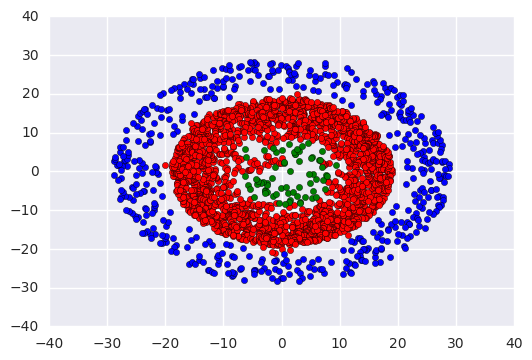

In [209]:
colors = ["red", "blue", "green", "orange", "yellow"]
ccount = 0
for ii in dist:
    plt.scatter(dat[dist[ii], 0],
                dat[dist[ii], 1],
                c=colors[ccount],)
    ccount += 1
plt.show()

In [238]:
# initialize dbscan object
dbscan = DBSCAN(eps=0.15,
                min_samples=10,
                metric="euclidean",)

# fit and predict labels with dbscan
label_dbscan = dbscan.fit_predict(dat_std)
label_dbscan[label_dbscan==-1].shape

(511,)

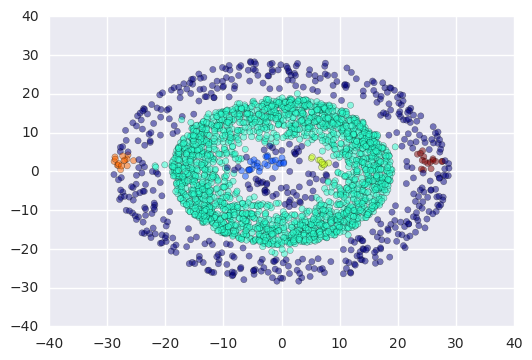

In [236]:
plt.scatter(xx, yy, c=label_dbscan, alpha=0.5, cmap="jet")
plt.show()

### Expectation Maximization clustering

A Gaussian mixture model is similar to kmeans, and uses and expectation-maximization approach to find clusters. the hidden variable here is the cluster label that a data point belongs to. It proceeds roughly in the following way.

1) Initialize guess for location and shape of K Gaussians

2) Expectation step: for each point, find weights related to the probability of membership to each cluster

3) Maximization step: for each cluster, update the location, normalization, and shape based on all data points, using the weights from the previous step

4) Repeat steps 2-3 until convergence

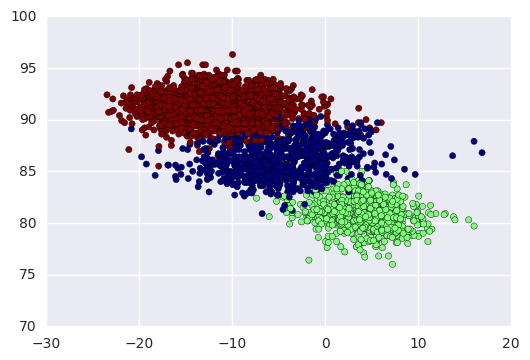

In [103]:
# import
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type="tied").fit(rh_pfx_intuit_stand)
label_gmm = gmm.predict(rh_pfx_intuit_stand)

plt.scatter(rh_pfx_intuit["ax"],
            rh_pfx_intuit["start_speed"],
            c=label_gmm,
            cmap="jet")

Initial inputs: Cluster number k, a database, stopping tolerance.

Output: A set of k-clusters with weight that maximize log-likelihood function.

Procedure:

1) Expectation step: For each database record x, compute the membership probability of x in each cluster h = 1,…, k.

2) Maximization step: Update mixture model parameter (probability weight).

3) Stopping criteria: If stopping criteria are satisfied stop, else set j = j +1 and go to (1).

whether EM can be used to estimate the class labels for the data elements, while, at the same time, estimating the means and the covariances of the individual Gaussians in the mixture

We imagine the N data observations ~x1, ~x2, . . . , ~xN as having been generated sequentially through N different data generation events

Next, we bring into existence a sequenceof N scalar random variables Y = {y1, y2, . . . , yN} that correspond to the N observations X = {~x1, ~x2, . . . , ~xN} on an index-by-index basis. The variable yi will take on a random value from the set {1, 2, . . . , K}, the value corresponding to the Gaussian that was chosen for the production of ~xi. K is the number of gaussians

treating Y = {y1, y2, . . . , yN} as unobserved data allows us to use the EM algorithm for an iterative maximization of the log-likelihood for the data actually observed.

EM algorithm is iteration through two different steps. Expectionation step and maximization step.

Expectation step. Using the current best guess for the parameters ofthe data model, we construct an expressionfor the log-likelihood for all data, observed and unobserved, and, then, marginalize the expression with respect to theunobserved data. By marginalization in the Expectation Step we mean integration of the log-likelihood for all data over all possibilities for the unobserved data.

Maximization step. Given the expression resulting from the previous step, for the next guess we choose those values for the model parameters that maximize the expectation expression. 

We stop iterating through the two steps when any further change in the log-likelihood of the observed data falls below some small threshold.

Assume independent data points and create log-likelihood function for all data points (sum of all log-likelihood functions). Assume that we do not know which= element of X was drawn from which of the Gaussians. However, we do know that each element of the dataset X is characterized by a mixture probability function. Need prior associated with the lth gaussian. From independence, the probability distribution for the entire dataset is given by the multiplication of the probability of observing each data point given the parameterizations for the gaussians. This is the likelihood of the known observations given the parameters of the gaussians. P(x|theta) = L(theta|x). Want to find theta that maximizes the log-likelihood. Each data point x measured has a corresponding unobserved data point y.

Imagine each observation to be the result of N different generation events. Think of sequence of random variable y_i associated with each data point (each y_i is a Gaussian-selector random variable, and takes on a value from the set [1, number of gaussians]. Remember each gaussian has it's over mean and covariance). WE ARE TREATING Y AS UNOBSERVED DATA, WHERE WHY IS A GAUSSIAN BASED ON X AND PARAMETERS. So not maximize likelihood with respect to x and y (using marginal probability now). Recall p(x|y, theta)\*p(y) = p(x|theta) = L(theta|x,y). Lots of steps to simplify. To start, guess parameters for gaussians and calculate the posterior class probabilities at each data point. Then use prior to update values for priors, and means and standard deviations of gaussians.